# hypopy tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import hypo

## Joint hypocenter-velocity inversion with P-wave arrivals only

### Create first synthetic data

Define limits and build grid

In [2]:
xmin = 90.0
xmax = 211.0
ymin = 80.0
ymax = 211.0
zmin = 0.0
zmax = 101.0

dx = 10.0

g = hypo.Grid3D(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dx), np.arange(zmin, zmax, dx))

We need some receivers

In [3]:
rcv = np.array([[112., 115., 13.],
                    [151., 117., 17.],
                    [180., 115., 16.],
                    [113., 145., 11.],
                    [160., 150., 17.],
                    [185., 149., 15.],
                    [117., 184., 11.],
                    [155., 192.,  9.],
                    [188., 188., 10.],
                    [188., 186., 30.],
                    [188., 183., 60.]])
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [4]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + 2.*np.random.randn(nev),       # origin time
                 160. +  5.*np.random.randn(nev),                           # x
                 130. +  5.*np.random.randn(nev),                           # y
                  35. + 10.*np.random.randn(nev))).T                        # z

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4000 m/s

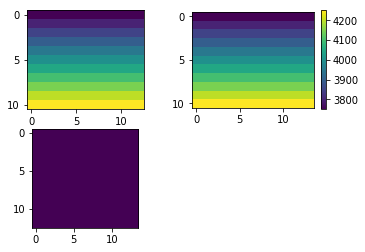

In [5]:
z = np.arange(zmin, zmax, dx) - 50.
Vz = 4000.0 + 5*z
Vp = np.kron(Vz, np.ones((g.shape[0], g.shape[1], 1)))

plt.subplot(221)
plt.imshow(np.squeeze(Vp[:,0,:].T))
plt.subplot(222)
plt.imshow(np.squeeze(Vp[0,:,:].T))
plt.colorbar()
plt.subplot(223)
plt.imshow(np.squeeze(Vp[:,:,4]))
plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the slowness vector
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

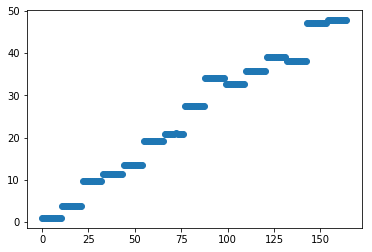

In [6]:
slowness = 1./Vp.flatten()

src = np.kron(src,np.ones((nsta,1)))
rcv = np.kron(np.ones((nev,1)), rcv)

tt = g.raytrace(slowness, src, rcv)

plt.plot(tt,'o')
plt.show()

Add some noise to the data

In [7]:
noise_variance = 1.e-3;  # 1 ms
tt += noise_variance*np.random.randn(tt.size)

Combine the event IDs, travel times, and receiver locations

In [8]:
data = np.hstack((src[:,0].reshape((-1,1)), tt.reshape((-1,1)), rcv))

### Initial hypocenter locations & velocity model

Note that for efficiency reason when computing matrix M, initial hypocenters
should _not_ be equal for any two event, e.g. they shoud all be different.

Here we place the initial coordinates more or less in the center of the grid.

In [9]:
hinit = np.vstack((np.arange(nev),
                   np.linspace(0., 50., nev),
                   160. + 0.1*np.random.randn(nev),
                   130. + 0.1*np.random.randn(nev),
                    35. + 0.1*np.random.randn(nev))).T

Initial velocity model is homogeneous

In [10]:
Vinit = 3900.0 + np.zeros((g.getNumberOfNodes(),))

### Velocity data points

For illustrative purposes, let's add two velocity point data to constrain the inversion

In [11]:
Vpts = np.array([[Vz[1], 110.0, 110.0, z[1]+50.],
                 [4000.0 + 5*(11.-50.), 112.0, 148.0, 11.0]])

### Calibration shots

Let's use 3 shots recorded at most receivers

In [12]:
ncal = 3
cal = np.vstack((5+np.arange(ncal),
                 np.zeros(ncal),
                 160. +  5.*np.random.randn(ncal),
                 130. +  5.*np.random.randn(ncal),
                   5. +     np.random.randn(ncal))).T

cal = np.kron(cal,np.ones((nsta,1)))
rcv = np.array([[112., 115., 13.],
                [151., 117., 17.],
                [180., 115., 16.],
                [113., 145., 11.],
                [160., 150., 17.],
                [185., 149., 15.],
                [117., 184., 11.],
                [155., 192.,  9.],
                [188., 188., 10.],
                [188., 186., 30.],
                [188., 183., 60.]])
rcv = np.kron(np.ones((ncal,1)), rcv)

ind = np.ones(rcv.shape[0], dtype=bool)
ind[3] = 0
ind[13] = 0
ind[15] = 0
cal = cal[ind,:]
rcv = rcv[ind,:]

tcal = g.raytrace(slowness, cal, rcv)
caldata = np.column_stack((cal[:,0], tcal, rcv, cal[:,2:]))

Before running the joint hypocenter-velocity inversion (JHVI), we use the constant velocity location algorithm.  This will improve convergence of the JHVI.

In [13]:
hinit, res = hypo.hypoloc(data, V=4000., hinit=hinit, maxit=15, convh=1., verbose=True)

 *** Hypocenter inversion ***

Locating hypocenters no 0
     Converged at iteration 2
Locating hypocenters no 1
     Converged at iteration 2
Locating hypocenters no 2
     Converged at iteration 1
Locating hypocenters no 3
     Converged at iteration 1
Locating hypocenters no 4
     Converged at iteration 2
Locating hypocenters no 5
     Converged at iteration 2
Locating hypocenters no 6
     Converged at iteration 1
Locating hypocenters no 7
     Converged at iteration 2
Locating hypocenters no 8
     Converged at iteration 2
Locating hypocenters no 9
     Converged at iteration 2
Locating hypocenters no 10
     Converged at iteration 1
Locating hypocenters no 11
     Converged at iteration 2
Locating hypocenters no 12
Locating hypocenters no 13
     Converged at iteration 1
Locating hypocenters no 14
     Converged at iteration 2


### Joint hypocenter-velocity Inversion parameters

In [14]:
Vlim = (3500., 4500., 1.0)
dmax = (50., 5., 2.e-3)
lagran = (1., 1., 1., 1.)

par = hypo.InvParams(maxit=2, maxit_hypo=10, conv_hypo=2, Vlim=Vlim, dmax=dmax,
                     lagrangians=lagran, invert_vel=True, verbose=True)

Run the inversion

 *** Joint hypocenter-velocity inversion ***

Building velocity data point matrix D
Building regularization matrix K

Starting iterations
Iteration 1 - Updating velocity model
                Updating penalty vector
                Raytracing


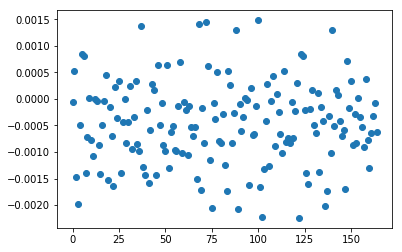

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 1 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

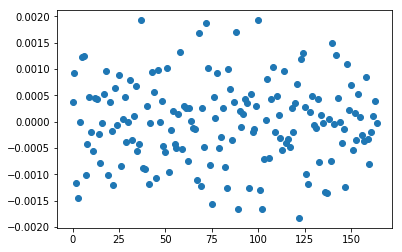

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
Iteration 2 - Relocating events
                Updating event ID 0 (1/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 1 (2/15)
                  Updating latitude & longitude - converged at iteration 2
                  Updating all hypocenter params - converged at iteration 2
                Updating event ID 2 (3/15)
        

In [15]:
h, V, sc, res = hypo.jointHypoVel(par, g, data, Vinit, hinit, caldata=caldata, Vpts=Vpts)